# Amazon Phone Reviews Analysis


Data Source: https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews <br>


Attribute Information:

1. asin - unique id of product
2. brand - Product Brand
3. verified - Valid Customer
4. Name - Reviewer Name
5. HelpfulVotes - Helpful Feedbacks
6. rating - rating between 1 and 5
7. Date - date of the review
8. title - brief summary of the review
9. body - text of the review
10. price - Product Price ($)


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

# 1- Loading the data

The dataset is available in two forms
1. .csv file

In [26]:
#to ignore warnings and have the plot
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#to fetch data from sqlite file
import sqlite3
#for preprocessing use the pandas dataframe
import pandas as pd
#numpy to feed to the algorithms
import numpy as np
#nltk for language related tasks
import nltk
#don't know why id imported this
import string
#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn for feature transformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#another metric to measure the performance of the model
from sklearn.metrics import roc_curve, auc
#stemming technique
from nltk.stem.porter import PorterStemmer


# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#word2 vec models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#to store and save the model
import pickle

#tqdm is to get the nice progress bar on loops
from tqdm import tqdm
import os



5    37752
1    12743
4     8824
3     4752
2     3915
Name: rating, dtype: int64
Number of data points in our data (63213, 8)


,asin,name,rating,date,verified,title,body,helpfulVotes
1,B0000SX2UC,Luke Wyatt,0.0,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,1.0,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
4,B0000SX2UC,tristazbimmer,1.0,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,J. White,1.0,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,the cell phone store owner,1.0,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0


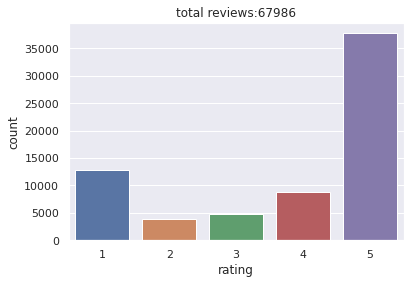

In [3]:
dtPhoneList = pd.read_csv("20191226-items.csv",sep=',')
all_review = pd.read_csv("20191226-reviews.csv", sep=',')

#plotting the reviews based on the original distribution
import seaborn as sns
sns.set(style="darkgrid")
#make count plots of all the data 
ax = sns.countplot(x="rating", data=all_review)
ax.set_title('total reviews:'+str(all_review.shape[0]))

#filtering only the data with positive and negative reviews just remove the 3 star rating reviews because the really
#dont help 

print(all_review['rating'].value_counts())

def num_toLabels(value):
    if value < 3:
        return int(0)
    if value >= 4:
        return int(1)
    
filtered_data = all_review
#changing reviews with score less than 3 to be negative and vice-versa
actualScore = filtered_data['rating']

positiveNegative = actualScore.map(num_toLabels) 

#now score become 1 or 0 ==> (1 for 4 or 5 stars || and 0 for 1 or 2 stars)
filtered_data['rating'] = positiveNegative #replace this as the actual column



filtered_data = filtered_data.dropna(subset=['rating', 'body'])

print("Number of data points in our data", filtered_data.shape)

filtered_data.head()


# # 2- preprocessing to clean the data 

# ## Select the duplicate rows and remove them if they occur in the data 

# 2- preprocessing to clean the data 

In [4]:
#Sorting data according to ProductId in ascending order
#sort the table with the product id column 
#axis 0 means that we want to sort row wise on the column selected
#sorting algorithm is quick sort
#we want to sort ascendingly
#we can also place NANs in the end to make sure that we have ended
#inplace basically means we don't wanna override the actual data 

sorted_data=filtered_data.sort_values('asin', 
                                      axis=0, 
                                      ascending=True, 
                                      inplace=False, 
                                      kind='quicksort',
                                      na_position='last')

In [5]:
sorted_data.tail(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
67948,B081H6STQQ,Geraldo f.,1.0,"August 17, 2019",True,Sony Xperia 1,"Sorry, this video is unsupported on this brows...",NaN
67949,B081H6STQQ,Alejandro Moreno,1.0,"October 16, 2019",True,Great phone,Overall this phone is perfect for what I need ...,NaN
67938,B081H6STQQ,kunfusion84,1.0,"November 11, 2019",True,Sony shines again,I absolutely love this phone!! Sony rarely dis...,2.0
67984,B081TJFVCJ,Tobiasz Jedrysiak,1.0,"December 24, 2019",True,Phone is like new,Product looks and works like new. Very much re...,NaN
67985,B0825BB7SG,Owen Gonzalez,1.0,"December 11, 2019",False,Outstanding phone for the price,I love the size and style of this phone. It is...,NaN


In [6]:
#sorting makes removal of duplicates slightly faster
#we want to remove the places that have the same "UserId","ProfileName","Time","Text"
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"asin","body"}, keep='first', inplace=False)
final.shape
#as we can now see we are down with 364k reviews from 525K reviews

(62439, 8)

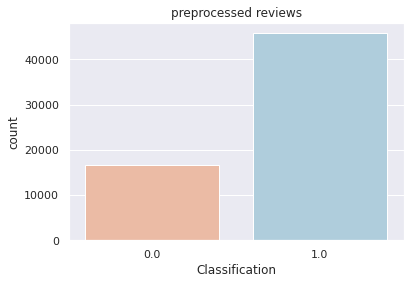

In [7]:
#How many positive and negative reviews are present in our dataset?
final = final.rename(columns={"rating": "Score", "body": "Text"})
final["Score"].value_counts() #gives the value counts of the positive and negative review seperation

#plotting the downsampled reviews to only positive and negative
sns.set(style="darkgrid")
#make count plots of all the data 
sns.countplot(x='Score', data=final, palette='RdBu')
plt.xlabel('Classification')
plt.title("preprocessed reviews")
plt.show()


# #let's see what the table looks like
# 
# 
# y_tr=final["Score"].values
# row=y_tr.shape[0]
# y_tr=y_tr.reshape(row,1)
# print(y_tr.shape)
# joblib.dump(y_tr,"y_labels_enw2v_e2v.pkl")
# 
# #use this to save the y_labels
# #y_labels=final["Score"]

In [8]:
import joblib
y_tr=final["Score"].values 
row=y_tr.shape[0] 
y_tr=y_tr.reshape(row,1) 
print(y_tr.shape) 
joblib.dump(y_tr,"y_labels_enw2v_e2v.pkl")
new = final[['Score','Text']]
new.to_csv("amzn_mobile_reviews.csv")
new.head()

(62439, 1)


,Score,Text
1,0.0,Due to a software issue between Nokia and Spri...
2,1.0,"This is a great, reliable phone. I also purcha..."
4,1.0,The phone has been great for every purpose it ...
5,1.0,"Hello, I have this phone and used it until I d..."
6,1.0,Cool. Cheap. Color: 3 words that describe the ...


In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not' #because these are cruicial bit of information
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [10]:
# Combining all the above stundents
!pip install emoji
import re

from bs4 import BeautifulSoup

def decontracted(phrase):
    """substitute stop words"""
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

##################emoji based preprocessing
import emoji
#load e2v file
e2v = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
#print the vocab of the file
e2v_words= list(e2v.wv.vocab)
#make a demojified vocab
demojized_e2v_words=[]
for word in e2v_words:
    new=emoji.demojize(word)
    demojized_e2v_words.append(new)


def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

def extract_emojis(str):
    # https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text
    return ' '.join(c for c in str if c in emoji.UNICODE_EMOJI) 

def emoji_convert(word):
    """emoji's are represented as->> :emoji_text: 
    we need to count the occurance of how many such patterns exist
    word>> -,👍 o/p - should be ":thumbsup:"
    word>> :👍  o/p - should be ":thumbsup:"
    word>> 👍®  o/p - should be ":thumbsup: :registered:
    basically extracts the emoji's only from the text
    """
    new_string_with_emoji= extract_emojis(word) #get's all the emoji's
    demojified=emoji.demojize(new_string_with_emoji)
    return demojified
    


#print(emoji.demojize("wtf is wrong with you 😂 ? 👍❤️😊"))



###############################################################

from tqdm import tqdm

preprocessed_reviews = []
# tqdm is for printing the status bar

emoji_ind=[] #denotes which sentence contains the emoji

i=0
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance) #remove html links
    sentance = BeautifulSoup(sentance, 'lxml').get_text() #remove html tags
    sentance = decontracted(sentance) #remove abbreviations
    sentance = re.sub("\S*\d\S*", "", sentance).strip() # remove words with numbers
    
    emoji_sent= text_has_emoji(sentance) #does emoji exist in sentence
    if(emoji_sent): #this checks if the review has emoji
        #if we are here this means we have emoji
        emojis_list=emoji_convert(sentance).split(" ") #gets all the emoji's in the sentence 
        #print(emojis_list) #this list contains all the emoji's in the sentence 
        emoji_ind.append(i) #store the emoji index number to keep track of it
        #now the emoji can be used as a individual word or mixed with a word or combination of multiple emojis
        demo=""#convert back to emoji 
        #apply special character transformation to only non emoji words as this will remove emoji's
        for word in sentance.split(): #for every word in the sentance 
            if word in e2v_words: #either the word itself is a direct emoji or a combination of characters and emoji #this means a direct emoji
                word=emoji.demojize(word)
            elif(text_has_emoji(word)): #the word is made up of emoji character
                word=emoji_convert(word)
            demo+=word+" "
        sentance=demo
        
    if not(emoji_sent): #if there is no emoji in the sentance
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)#then apply sentance substitute for normal regex
   

    sentance=sentance.strip()
    sentance=emoji.emojize(sentance)
    
    #sentance = re.sub('[^A-Za-z]+', ' ', sentance) # remove the special characters from the words using reg ex
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #join with spaces after removing stop words
    #sentance=emoji.emojize(sentance) #convert them back into their emoji form
    preprocessed_reviews.append(sentance.strip())
    i+=1

print(emoji_ind) #these sentences basically contain all the emoji's

    

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=df582d1d0596466dc4e71cd0581c55eb8f48742c6f967f97fbeeac3d951cfbdb
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


100%|██████████| 62439/62439 [00:18<00:00, 3348.65it/s]

[156, 157, 161, 504, 853, 1766, 3119, 3583, 3591, 4360, 4878, 6292, 6659, 6889, 6922, 7448, 7831, 8005, 8024, 8688, 8692, 9110, 9605, 9858, 9879, 9888, 10019, 10181, 10297, 10404, 10595, 10649, 10869, 11099, 11277, 11305, 11637, 11748, 11844, 11912, 12026, 12045, 12178, 12187, 12812, 12902, 12968, 13121, 13130, 13256, 13315, 13335, 13492, 13496, 13734, 13824, 14037, 14093, 14119, 14131, 14192, 14336, 14372, 14518, 14674, 14853, 14953, 14961, 14987, 15142, 15300, 15309, 15630, 15662, 15909, 15997, 16109, 16230, 16336, 16389, 16543, 16685, 16807, 16884, 17071, 17185, 17425, 17513, 17626, 17746, 17851, 17905, 17952, 18459, 18545, 18718, 19045, 19140, 19234, 19338, 19702, 19793, 19832, 19849, 19890, 20128, 20179, 20181, 20251, 20303, 20353, 20570, 20934, 21044, 21211, 21431, 21503, 21527, 21550, 21569, 21586, 21653, 21768, 21837, 21851, 21937, 22004, 22061, 22226, 22412, 22622, 22686, 22699, 22747, 22769, 23173, 23247, 23491, 23517, 23594, 23601, 23606, 23792, 23850, 23855, 23959, 24006, 2

In [11]:
#print all the emoji present rows
i = 0
for element in emoji_ind:
    if i<10:
      i += 1
      print("\n=========my preprocessed review========")
      print(preprocessed_reviews[element]) #get all the reviews
      print("\n=========this is the original review========")
      print(final["Text"].values[element])
      print(final["Score"].values[element])


=========my preprocessed review========
😆

=========this is the original review========
😆
1.0

=========my preprocessed review========
😊

=========this is the original review========
😊
1.0

=========my preprocessed review========
actually not even deserve star. disappointed. not hold charge all..thanks lot selling piece 🙁

=========this is the original review========
Actually it doesn't even deserve 1 star. Very disappointed. It will not hold a charge at all..thanks a lot for selling me a piece of crap.🙁
0.0

=========my preprocessed review========
motorla flip phone! make sure order new battery one got last two hours! bought extended battery cover last days days! great phone great packing fast delivery, seller failed mention battery worthless! 🐖 love phone! star phone! stars side buttons deteriorated joke! military grade thi nk not

=========this is the original review========
Motorla flip phone! Make sure you order a new battery the one I got last two hours! I bought an extended bat

0it [00:00, ?it/s]


There are 1824608 words in the combination of all pos review.
There are 575005 words in the combination of all neg review.


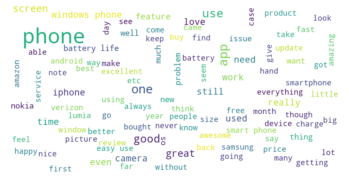

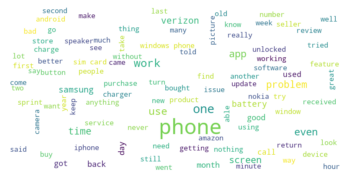

this is the len of the text : 11386522


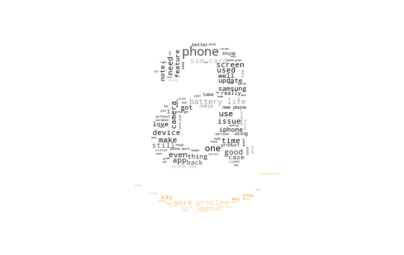

In [12]:
#generate positive and negative words word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

pos_text=""
neg_text=""

i=0
for review,score in tqdm(zip(preprocessed_reviews,final["Score"])):
    if(score==1):
        pos_text += review
    else:
        neg_text += review
    i+=1
    if(i>10000):
        break
        
print ("There are {} words in the combination of all pos review.".format(len(pos_text)))
print ("There are {} words in the combination of all neg review.".format(len(neg_text)))


#positive word cloud 
wordcloud = WordCloud(width=800, height=400,max_font_size=50, max_words=100, background_color="white").generate(pos_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#negative word cloud
wordcloud = WordCloud(width=800, height=400,max_font_size=50, max_words=100, background_color="white").generate(neg_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Start with one review:

text=""

for review in preprocessed_reviews:
    text+=review
    
print("this is the len of the text : {}".format(len(text)))
    
#load the masking image  for amazon image 




#amazon word cloud for all the reviews in the image 
from wordcloud import ImageColorGenerator

# Generate a word cloud image
mask = np.array(Image.open("amzn.png"))
wordcloud_usa = WordCloud( background_color="white", mode="RGBA", max_words=300, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("masked_amazon.png", format="png")

plt.show()




In [13]:
#bigrams representations of common words in both the segments

#top 20 bigrams in the data after preprocessing
#we use the bigrams because unigram will have alot of common words in both the categories

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

pos_review=[]
neg_review=[]
for review,score in zip(preprocessed_reviews,final["Score"]):
    if (score==1):
        pos_review.append(review)
    else:
        neg_review.append(review)

#seperates the pos review and neg reviews into 2 different lists
print(len(pos_review),len(neg_review))


common_words_pos = get_top_n_words(pos_review, 20)
common_words_neg = get_top_n_words(neg_review, 20)

#print pos review count
#print("this is the positive side")
#for word, freq in common_words_pos:
    #print(word, freq)

#print neg review count
#print("this is the negative side")
#for word, freq in common_words_neg:
    #print(word, freq)
    

df_pos = pd.DataFrame(common_words_pos, columns = ['ReviewText' , 'count'])
# df_pos.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    # kind='bar', yTitle='Count', linecolor='black', title='Top 20 pos words in review after removing stop words')
print(df_pos.head())

df_neg = pd.DataFrame(common_words_neg, columns = ['ReviewText' , 'count'])
# df_neg.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 neg words in review after removing stop words')
print(df_neg.head())



45810 16629
     ReviewText  count
0  battery life   4461
1   great phone   3699
2    love phone   2340
3     phone not   2056
4      sim card   1899
  ReviewText  count
0  phone not   2293
1   not work   1774
2  would not   1298
3  could not   1058
4   sim card    964


# feature transformation

#  training a w2vec

In [14]:
i=0
list_of_sentance=[]

for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())
    
print(list_of_sentance[911])
    
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need


# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=300, workers=-1)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print("saving the model to disk")
w2v_model.wv.save_word2vec_format('my_model.bin')

100%|██████████| 62439/62439 [00:00<00:00, 200585.58it/s]


['quick', 'shipping', 'used', 'product', 'works', 'great', 'no', 'issues']
[('recall', 0.21461144089698792), ('plus', 0.20841330289840698), ('borrowed', 0.2068723738193512), ('increases', 0.2063121199607849), ('importante', 0.200521320104599), ('optimizations', 0.1952669769525528), ('saver', 0.18983745574951172), ('baseband', 0.18921446800231934), ('removing', 0.18590539693832397), ('descriptions', 0.1848619282245636)]
[('confortable', 0.2171018123626709), ('qualified', 0.1945611536502838), ('instant', 0.1920045018196106), ('approach', 0.1882505714893341), ('(', 0.1870245337486267), ('offers', 0.18365097045898438), ('ending', 0.18307369947433472), ('cellular', 0.17972707748413086), ('proof', 0.17899882793426514), ('triangle', 0.17855742573738098)]
saving the model to disk


In [15]:
#word to vector model
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#emoji to vector
#https://github.com/uclnlp/emoji2vec
e2v_words= list(e2v.wv.vocab)
print("loading emoji to vector from the e2v word file",len(e2v_words))
print("sample emoticons", e2v_words[0:50])

number of words that occured minimum 5 times  10329
sample words  ['due', 'software', 'issue', 'nokia', 'sprint', 'phone', 'text', 'messaging', 'capabilities', 'not', 'work', 'system', 'patch', 'comes', 'time', 'next', 'months', 'spend', 'least', 'hour', 'award', 'winning', 'customer', 'service', 'team', 'find', 'someone', 'admit', 'problem', 'designed', 'phones', 'incoming', 'messages', 'quickly', 'viewed', 'offline', 'way', 'providers', 'however', 'likes', 'people', 'hook', 'server', 'first', 'stay', 'connected', 'burning', 'minutes', 'check', 'inbox']
loading emoji to vector from the e2v word file 1661
sample emoticons ['🇸🇰', '👔', '🌀', '🚾', '👹', '🚻', '👬', '🇫🇯', '🎧', '🐽', '🚜', '♋', '🚭', '🚷', '📅', '💈', '✔️', '🙎🏼', '🍸', '🤷', '🌂', '🚓', '🍤', '💘', '🚔', '👚', '🐧', '🍥', '🍵', '✂️', '👓', '⛔', '💂', '🆔', '😕', '🎎', '🏊🏻', '❗', '💭', '💬', '🎴', '♉', '⚖', '🇮🇩', '🛵', '⬅️', '📒', '😡', '🇲🇦', '🇨🇭']


# tf-idf word2vec

In [16]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

#since the tdidf vectorizer class removes all the patterns we need to save the emoji patterns
model = TfidfVectorizer(token_pattern=r'[^\s]+') #regex pattern to keep emoji
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))#dict of word_name: idf score
print(dictionary["®"])

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec_eng = np.zeros(300) # as word vectors are of zero length #might have to change this if using self word2vec model
    sent_e2vec= np.zeros(300) #emoji vector are of zero length 
    weight_sum_w2v =0; # num of words with a valid vector in the sentence/review
    weight_sum_e2v=0;
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) or (word in e2v_words)) and (word in tfidf_feat):
            if(word in w2v_words):
                w2vec = w2v_model.wv[word]
                tf_idf_w2v = dictionary[word]*(sent.count(word)/len(sent)) #idf*tf
                sent_vec_eng += (w2vec * tf_idf_w2v) #compute the tf-idf score for each vec and add that to previous score
                weight_sum_w2v+=tf_idf_w2v
            elif(word in e2v_words):
                e2vec = e2v.wv[word]
                tf_idf_e2v = dictionary[word]*(sent.count(word)/len(sent)) #idf*tf
                sent_e2vec += (e2vec*tf_idf_e2v)
                weight_sum_e2v+=tf_idf_e2v
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
    if weight_sum_w2v != 0:
        sent_vec_eng /= weight_sum_w2v #calculte avg w2vec,tfidf score
        
    if weight_sum_e2v != 0:
        sent_e2vec /= weight_sum_e2v #calculte avg w2vec,tfidf score   
        
    final=np.concatenate((sent_vec_eng, sent_e2vec))
    tfidf_sent_vectors.append(final) #after all the words are feed then update the sentence vec to the list 

  0%|          | 9/62439 [00:00<23:42, 43.89it/s]

10.096051225574055


100%|██████████| 62439/62439 [10:06<00:00, 102.97it/s]


In [17]:
#save the model 
from sklearn.externals import joblib
print(len(tfidf_sent_vectors))
X_tr=np.asarray(tfidf_sent_vectors)
joblib.dump(X_tr, 'tf_idf_enw2v_e2v.pkl')
#get the final preprocessed data into pd data frame
tf_idf_final_avg_w2v= pd.DataFrame(tfidf_sent_vectors)
print(tf_idf_final_avg_w2v.shape)

62439
(62439, 600)


In [18]:
from sklearn.externals import joblib
X_tr=joblib.load('tf_idf_enw2v_e2v.pkl')
y_tr=joblib.load("y_labels_enw2v_e2v.pkl")
print(X_tr.shape,y_tr.shape)
#print(type(y_tr),type(X_tr))
# X_tr

(62439, 600) (62439, 1)


# Algorithm implementations using KNN, ANN

In [19]:
#loading the data and standardizing it before actually implemnting algorithms
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import numpy as np


X_tr_complete = joblib.load('tf_idf_enw2v_e2v.pkl')
y_tr_complete = joblib.load("y_labels_enw2v_e2v.pkl")
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

shapes=y_tr_complete.shape
# y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,

#standardization of the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_tr_complete))
X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))

#train test split and random splitting
from sklearn.model_selection import train_test_split
# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)

#since it is computational heavy to evaluate a ten fold evaluation for all the different hyperparameters such as
#1 k value 
#2 uniform or weighted 
#3 distance type

#we will now prioritize the bottom 2 first by a 80-20 split and evaluating their performance to see which parameter best performs
#then upon deciding a rough estimate of these parameters we will then try to implement a 10 fold evalution to find the main hyper parameter that is k



(62439, 300)
StandardScaler(copy=True, with_mean=True, with_std=True)
this is my new X_tr:(62439, 300)
are both the array's equal:  False
==================== train data (80%)====================
(49951, 300) (49951, 1)
==================== test data (20%)====================
(12488, 300) (12488, 1)


# K nearest neighbour algorithm

1. we are now implementing the KNN algorithm to find the right k value, 
2. the weight association {wether we want weighted or uniform} 
3. and finally the distance metric to see the impact of the distances on knn

In [20]:
#let's try to implement and fix our knn for the distance and the weight scheme used 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics #for confusion matrix
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from tqdm import tqdm
import time

start=time.time()
#simple classifier to see the runtime execution
clf_1=KNeighborsClassifier(algorithm="brute",n_jobs=-1)
print("fitting.........")
clf_1.fit(X_tr,y_tr)
print("getting predictions.........")
y_pred=clf_1.predict(X_test)
print("computing scores............")
_f1=f1_score(y_test,y_pred)
_acc=accuracy_score(y_test,y_pred)
print(_f1,_acc)
end=time.time()
print("total_execution time: {}".format(end-start))

#setting up the tuning parameters
tuned_parameters = {'metric': ["euclidean","manhattan","chebyshev","cosine"],"weights":["uniform","distance"]}

accuracy_list=[]
f1_list=[]


#run for all metrics
for _metric in tqdm(tuned_parameters["metric"]):
    #setting up the default k=5 and weights =uniform
    clf_1=KNeighborsClassifier(algorithm="brute",weights="uniform",metric=_metric,n_jobs=-1)
    clf_1.fit(X_tr,y_tr)
    y_pred=clf_1.predict(X_test)
    _f1=f1_score(y_test,y_pred)
    _acc=accuracy_score(y_test,y_pred)
    accuracy_list.append(_acc)
    f1_list.append(_f1)

print("accuracies:{} and f1_score:{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(tuned_parameters["metric"]))





fitting.........
getting predictions.........


  0%|          | 0/4 [00:00<?, ?it/s]

computing scores............
0.8639863130881095 0.7835522101217168
total_execution time: 21.76689577102661


100%|██████████| 4/4 [05:14<00:00, 78.67s/it]

accuracies:[0.7835522101217168, 0.780829596412556, 0.763613068545804, 0.8158231902626522] and f1_score:[0.8639863130881095, 0.8618583758138596, 0.852900139525613, 0.8766888269354494]
metrics tested :['euclidean', 'manhattan', 'chebyshev', 'cosine']


In [21]:
print("accuracies:{} and f1_score:{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(tuned_parameters["metric"]))

accuracies:[0.7835522101217168, 0.780829596412556, 0.763613068545804, 0.8158231902626522] and f1_score:[0.8639863130881095, 0.8618583758138596, 0.852900139525613, 0.8766888269354494]
metrics tested :['euclidean', 'manhattan', 'chebyshev', 'cosine']


Text(0.5, 12.5, 'Predicted label')

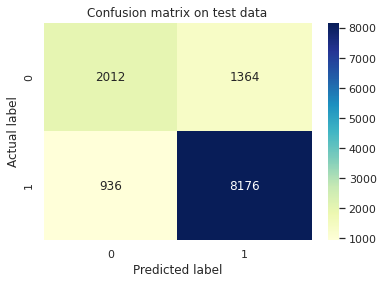

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Artificial Neural Network

In [ ]:
!pip install lz4

In [25]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

(49951, 300) (49951, 2) (12488, 300) (12488, 2)
{0: 1.884516713197012, 1: 0.6805684233473214}
total size of the network is 15 layers
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               

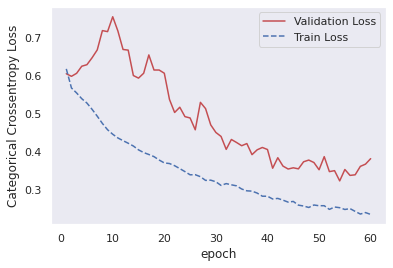

In [26]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
import time
import tensorflow as tf

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    """plot x wrt vy and x wrt ty"""
    ax.plot(x, vy, 'r', linestyle="solid", label="Validation Loss")
    ax.plot(x, ty, 'b', linestyle="dashed",label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.show()

tr_x,tr_y,te_x,te_y=X_tr, y_tr, X_test, y_test

categorical_values=2 #this means the total labels we have so 2 because pos and neg
te_y=np_utils.to_categorical(te_y, categorical_values) 
tr_y=np_utils.to_categorical(tr_y, categorical_values) 
print(tr_x.shape,tr_y.shape,te_x.shape,te_y.shape)

#assign class weights for one hot encoded classes
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tr_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

print(d_class_weights)

#only softmax classifier

#some model parameters 
output_dim = tr_y.shape[1] #this is class labels 2
input_dim = tr_x.shape[1] #this is basically 300


batch_size = 256
num_nodes_in_between=15-2 #this means layers
nb_epoch=60
batch_norm_after_layer=2
print("total size of the network is {} layers".format(num_nodes_in_between+2))

#with strategy.scope():
start=time.time()

model_best = tf.keras.models.Sequential()

#add layer 1 
model_best.add(Dense(100, activation='relu', input_shape=(input_dim,)))
model_best.add(Dropout(0.33))
#model_best.add(BatchNormalization())

#add subsequent layers 

for i in range(1,num_nodes_in_between+1):
    model_best.add(Dense(100, activation='relu'))
    model_best.add(Dropout(0.33))
    if(i%batch_norm_after_layer==0):
        model_best.add(BatchNormalization())
        
#add final softmax layer
model_best.add(Dense(output_dim, activation='softmax'))
model_best.summary()

#compile the model
model_best.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

#checkpoint the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.hdf5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callbacks_list = [checkpoint]

#fit the model
history = model_best.fit(tr_x, tr_y, batch_size=batch_size, epochs=nb_epoch, validation_data=(te_x, te_y),callbacks=callbacks_list) 
score = model_best.evaluate(te_x, te_y, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

end=time.time()
print("the total time :",end-start)

import matplotlib.pyplot as plt
#get the plots
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

vy = history.history['val_loss'] #validation means this is the test loss 
ty = history.history['loss'] #this is the train loss

plt_dynamic(x, vy, ty, ax)